In [1]:
#import jax
import jax.numpy as jnp
import jax.random as random

import jax_cosmo as jc

import numpyro
from numpyro import sample
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoMultivariateNormal
from numpyro.infer import init_to_value, Trace_ELBO, SVI
from optax import adam

import matplotlib.pyplot as plt

import arviz as az

import numpy as np

import emcee_jax

In [2]:
#from em import *

In [3]:
key = random.PRNGKey(3141)
key, subkey, subkey2, subkey3 = random.split(key, 4)

## Creating some data

In [4]:
!export JAX_ENABLE_X64=TRUE

In [5]:
shape = (2000,)
z_random = random.uniform(key, shape, minval=0.01, maxval=1.5)
z = jnp.sort(z_random)

In [6]:
z

DeviceArray([0.01022949, 0.01116165, 0.01366114, ..., 1.4987795 ,
             1.4995131 , 1.499763  ], dtype=float32)

In [7]:
true_param = {'h':0.7,
    'Omega_m':0.29,
    'w0':-1.02,
    'wa':0.01}

In [8]:
cosmology = jc.Cosmology(h=true_param['h'], Omega_c=true_param['Omega_m']-0.05, Omega_b=0.05, w0=true_param['w0'], wa=true_param['wa'], Omega_k=0., n_s=0.96, sigma8=0.83)
dist_L = (jc.background.angular_diameter_distance(cosmology, 1.0)/1.0**2.0)/0.67
dist_L

/home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


DeviceArray([0.], dtype=float32)

In [9]:
def distance_modulus(theta, z):
    a = jc.utils.z2a(z)
    h = theta.get('h', 0.7)
    Omega_m = theta.get('Omega_m', 0.3)
    Omega_b = 0.05
    Omega_c = Omega_m - Omega_b
    Omega_k = theta.get('Omega_k', 0.)
    w0 = theta.get('w0', -1.)
    wa = theta.get('wa', 0.)
    
    cosmology = jc.Cosmology(h=h, Omega_c=Omega_c, Omega_b=Omega_b, w0=w0, wa=wa, Omega_k=Omega_k, n_s=0.96, sigma8=0.83)
    dist_L = (jc.background.angular_diameter_distance(cosmology, a)/a**2.0)/h
    dist_mod = 25.0 + 5.0 * jnp.log10(dist_L)
    return dist_mod

In [10]:
sigma0 = 0.1
sigma = sigma0 * jnp.log(1+z)
dist_mod_err = sigma #* random.uniform(subkey, shape, minval=-sigma0, maxval=sigma0) 

cov = jnp.diag(sigma**2.0)

In [11]:
dist_mod = distance_modulus(true_param, z) + dist_mod_err

Text(0, 0.5, 'distance modulus')

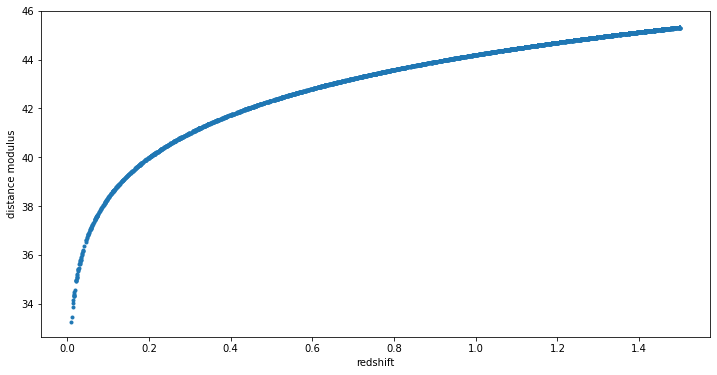

In [12]:
plt.figure(figsize=(12,6))
plt.errorbar(z, dist_mod, yerr = sigma, marker='.', linestyle='')
plt.xlabel('redshift')
plt.ylabel('distance modulus')

## Setting up the model

In [13]:
def model_cpl(x, y, sig):
    cov = jnp.diag(sig**2)
    Omega_m = sample("Omega_m", dist.Uniform(0,1))
    w0 = sample("w0", dist.Uniform(-10, 10))
    wa = sample("wa", dist.Uniform(-10,10))
    theta_dict = {"Omega_m":Omega_m, "w0":w0, "wa":wa}
    mu = distance_modulus(theta_dict, x)
    
    sample("y", dist.MultivariateNormal(mu, cov), obs=y)

## Running the optimizer

In [14]:
initial_values = {'Omega_m':0.5, 'w0':-1., 'wa':0.}

In [15]:
guide_cpl = AutoMultivariateNormal(model_cpl, 
                                   init_loc_fn = init_to_value(values=initial_values))

In [15]:
svi = SVI(model_cpl, 
    guide_cpl, 
    adam(0.01), 
    Trace_ELBO(),     
    x = z,
    y = dist_mod,
    sig = sigma
)

In [16]:
svi_result = svi.run(subkey2, 1000)

/home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
  2%|▏         | 15/1000 [00:04<04:23,  3.74it/s]


KeyboardInterrupt: 

In [ ]:
svi_result.params

{'auto_loc': DeviceArray([-0.6060317 , -0.22931151, -0.49325305], dtype=float32),
 'auto_scale_tril': DeviceArray([[ 0.04770408,  0.        ,  0.        ],
              [-0.00432543,  0.02005947,  0.        ],
              [-0.05101621, -0.17809437,  0.09513464]], dtype=float32)}

In [ ]:
samples = guide_cpl.sample_posterior(subkey3, svi_result.params, (10000,))
idata_num = az.from_dict(samples)

In [ ]:
az.summary(idata_num, kind='stats')

,mean,sd,hdi_3%,hdi_97%
Omega_m,0.353,0.011,0.332,0.373
w0,-1.141,0.101,-1.342,-0.958
wa,-2.400,0.965,-4.203,-0.571


In [ ]:
Omegam_mean = idata_num.posterior.Omega_m.mean()
Omegam_mean = Omegam_mean.to_numpy()

In [44]:
w0_m = idata_num.posterior.w0.mean()
w0_m = w0_m.to_numpy()

In [45]:
wa_m = idata_num.posterior.wa.mean()
wa_m = wa_m.to_numpy()

In [51]:
sampled_means = {'Omega_m': Omegam_mean,
'w0' : w0_m,
'wa' : wa_m
}

In [46]:
var_dict = {"Omega_m" : r"$\Omega_{m,0}$",
               "w0" :  r"$w_0$",
               "wa" : r"$w_a$"}   

ref_dict = {var_dict["Omega_m"] : true_param['Omega_m'],
               var_dict["w0"] :  true_param['w0'],
               var_dict["wa"] : true_param['wa']}   
 

In [ ]:
              
labeller = az.labels.MapLabeller(var_name_map=var_dict)

az.plot_pair(idata_num, kind='kde', marginals=True, figsize=(10,10), textsize=16, contour=False, labeller=labeller, reference_values=ref_dict)

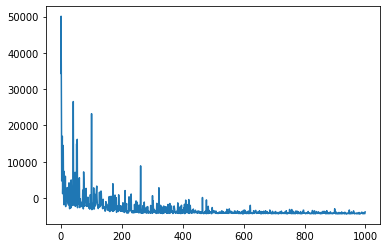

In [53]:
plt.plot(svi_result.losses)

Text(0, 0.5, 'distance modulus')

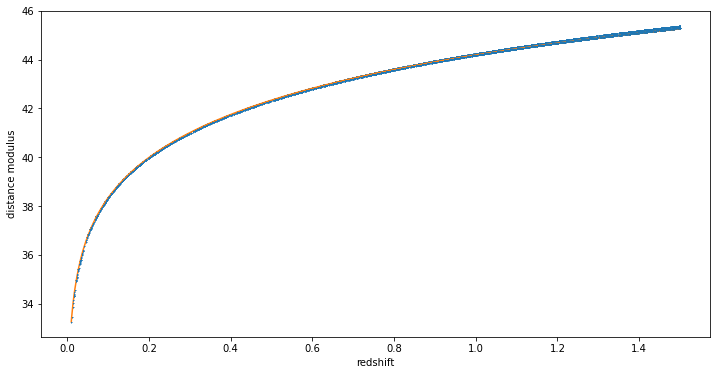

In [60]:
plt.figure(figsize=(12,6))
plt.errorbar(z, dist_mod, yerr = sigma, marker='+', ms=1, linestyle='')
plt.plot(z, distance_modulus(sampled_means, z))
plt.xlabel('redshift')
plt.ylabel('distance modulus')

In [61]:
from numpyro.infer import MCMC, NUTS

In [62]:
mcmc_key = random.PRNGKey(1234)
kernel = NUTS(model_cpl)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, z, dist_mod, sigma)
mcmc.print_summary()

  0%|          | 0/1000 [00:00<?, ?it/s]/home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
sample: 100%|██████████| 1000/1000 [05:03<00:00,  3.30it/s, 115 steps of size 4.55e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.24      0.02      0.25      0.22      0.27    127.40      1.00
        w0     -1.03      0.02     -1.03     -1.06     -1.00    136.63      1.00
        wa     -0.03      0.17     -0.03     -0.34      0.25    129.12      1.00

Number of divergences: 0


In [69]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.24      0.02      0.25      0.22      0.27    127.40      1.00
        w0     -1.03      0.02     -1.03     -1.06     -1.00    136.63      1.00
        wa     -0.03      0.17     -0.03     -0.34      0.25    129.12      1.00

Number of divergences: 0


In [63]:
true_param

{'h': 0.7, 'Omega_m': 0.29, 'w0': -1.02, 'wa': 0.01}

In [67]:
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive

In [72]:
posterior_samples = mcmc.get_samples()
#posterior_predictive = Predictive(model_cpl, posterior_samples)(
#    mcmc_key, dist_mod, 
#)
#prior = Predictive(model, num_samples=500)(
#    PRNGKey(2), eight_school_data["J"], eight_school_data["sigma"]
#)

numpyro_data = az.from_dict(
    posterior_samples
    #prior=prior,
    #posterior_predictive=posterior_predictive,
    #coords={"school": np.arange(eight_school_data["J"])},
    #dims={"theta": ["school"]},
)

array([[<AxesSubplot:ylabel='$\\Omega_{m,0}$'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='$w_0$'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='$\\Omega_{m,0}$', ylabel='$w_a$'>,
        <AxesSubplot:xlabel='$w_0$'>, <AxesSubplot:xlabel='$w_a$'>]],
      dtype=object)

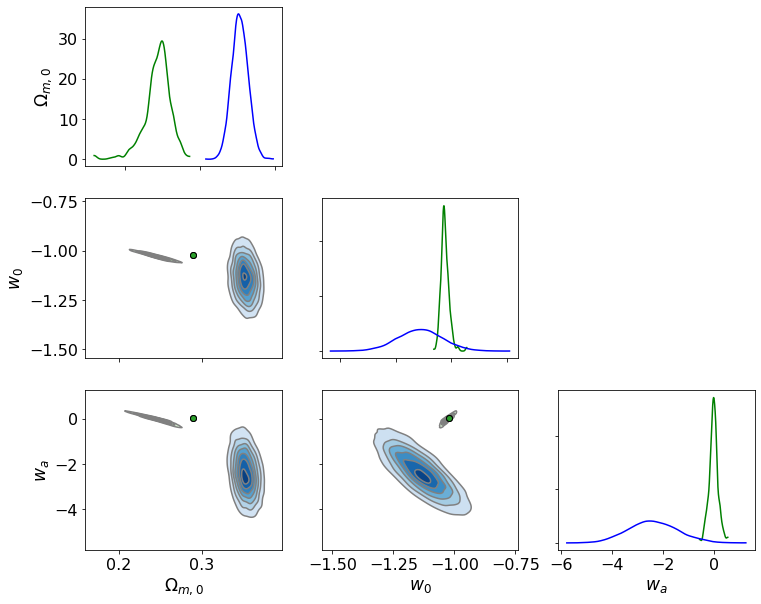

In [81]:
fig, ax = plt.subplots(3,3, figsize=(12,10))
labeller = az.labels.MapLabeller(var_name_map=var_dict)

az.plot_pair(numpyro_data, kind='kde', marginals=True, figsize=(10,10), textsize=16, contour=False, labeller=labeller, reference_values=ref_dict, ax=ax, marginal_kwargs={'color':'green'},
kde_kwargs={"contourf_kwargs": {"cmap": "Greens"}})

az.plot_pair(idata_num, kind='kde', marginals=True, figsize=(10,10), textsize=16, contour=False, labeller=labeller, reference_values=ref_dict, kde_kwargs={"contourf_kwargs": {"cmap": "Blues"}},
ax=ax, marginal_kwargs={'color':'blue'})

## emcee

In [16]:
distance_modulus(true_param, np.asarray(z))

DeviceArray([33.254223, 33.443607, 33.882393, ..., 45.211433, 45.212746,
             45.21319 ], dtype=float32)

In [17]:
from emcee_jax.host_callback import wrap_python_log_prob_fn

In [18]:
np.asarray(distance_modulus(true_param, np.asarray(z)))

array([33.254223, 33.443607, 33.882393, ..., 45.211433, 45.212746,
       45.21319 ], dtype=float32)

In [19]:
def log_likelihood(x, y, sig, theta_dict):
    distance_mod = np.asarray(distance_modulus(theta_dict, x) , dtype=float)
    log_like = -0.5 * ((y - distance_mod)**2.0/sig**2.0)
    return log_like

In [20]:
def log_prior(Omega_m=0.3, w_0=-1, w_1=0):
    '''returns the log of the propability densities up to a constant'''
    if 0.0 < Omega_m < 1.0:
        return -((w_0+1.0)**2.0/5.0**2.0 + (w_1)**2.0/5.0**2.0) 
    return -100000000

In [23]:
@wrap_python_log_prob_fn
def log_probability(theta, x=z, y=dist_mod, sig=sigma):
    '''performs the multiplication prior*likelihood'''
    keys = ['Omega_m', 'w_0', 'w_1']
    theta_dict = dict(zip(keys, theta))
    lp = log_prior(**theta_dict)
    if not jnp.isfinite(lp):
        return -jnp.inf
    return lp + log_likelihood( x, y, sig, theta_dict)
    #return log_likelihood( x, y, sig, theta_dict)

In [24]:
trp = jnp.asarray(list(true_param.values()))
trp

DeviceArray([ 0.7 ,  0.29, -1.02,  0.01], dtype=float32)

In [25]:
z

DeviceArray([0.01022949, 0.01116165, 0.01366114, ..., 1.4987795 ,
             1.4995131 , 1.499763  ], dtype=float32)

In [26]:
dist_mod

DeviceArray([33.25524 , 33.444717, 33.88375 , ..., 45.303013, 45.304356,
             45.30481 ], dtype=float32)

In [27]:
sigma

DeviceArray([0.00101775, 0.00110999, 0.00135687, ..., 0.09158024,
             0.0916096 , 0.0916196 ], dtype=float32)

In [29]:
log_probability(trp)

ERROR:absl:Outside call <jax.experimental.host_callback._CallbackWrapper object at 0x7f6eb5463ee0> threw exception Callback func <jax.experimental.host_callback._CallbackWrapper object at 0x7f6eb5463ee0> should have returned a result with abstract values ShapedArray(float32[]) but returned ShapedArray(float32[2000]).


XlaRuntimeError: INTERNAL: Generated function failed: TypeError: Callback func <jax.experimental.host_callback._CallbackWrapper object at 0x7f6eb5463ee0> should have returned a result with abstract values ShapedArray(float32[]) but returned ShapedArray(float32[2000])

At:
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/experimental/host_callback.py(1296): _outside_call_run_callback
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/experimental/host_callback.py(1173): wrapped_callback
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/_src/dispatch.py(615): _execute_compiled
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/_src/dispatch.py(100): apply_primitive
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/experimental/host_callback.py(984): _outside_call_impl
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/core.py(675): process_primitive
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/core.py(326): bind_with_trace
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/core.py(323): bind
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/core.py(390): eval_jaxpr
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/core.py(192): jaxpr_as_fun
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/_src/custom_batching.py(128): custom_vmap_impl
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/core.py(675): process_primitive
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/core.py(326): bind_with_trace
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/core.py(323): bind
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/_src/custom_batching.py(71): __call__
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/jax/_src/traceback_util.py(162): reraise_with_filtered_traceback
  /tmp/ipykernel_124789/1528938840.py(1): <cell line: 1>
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3397): run_code
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3337): run_ast_nodes
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3134): run_cell_async
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/IPython/core/interactiveshell.py(2935): _run_cell
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/IPython/core/interactiveshell.py(2880): run_cell
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/ipykernel/zmqshell.py(532): run_cell
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/ipykernel/ipkernel.py(360): do_execute
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/ipykernel/kernelbase.py(662): execute_request
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/ipykernel/kernelbase.py(367): dispatch_shell
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/ipykernel/kernelbase.py(460): process_one
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/ipykernel/kernelbase.py(471): dispatch_queue
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/asyncio/events.py(80): _run
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/asyncio/base_events.py(1896): _run_once
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/asyncio/base_events.py(600): run_forever
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/tornado/platform/asyncio.py(199): start
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/ipykernel/kernelapp.py(677): start
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/traitlets/config/application.py(846): launch_instance
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/site-packages/ipykernel_launcher.py(16): <module>
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/runpy.py(86): _run_code
  /home/santiago/anaconda3/envs/diffstuff/lib/python3.10/runpy.py(196): _run_module_as_main


In [ ]:
log_probability(trp)

DeviceArray([-188.08003 , -159.79253 , -109.5749  , ...,  -20.953108,
              -20.94889 ,  -20.947298], dtype=float32)

In [ ]:
random.split(random.PRNGKey(0), 3)

DeviceArray([[2467461003,  428148500],
             [3186719485, 3840466878],
             [2562233961, 1946702221]], dtype=uint32)

In [126]:
kkey1, kkey2, kkey3 = random.split(random.PRNGKey(0), 3)

In [127]:
kkey3

DeviceArray([2562233961, 1946702221], dtype=uint32)

In [128]:
em.EnsembleSampler?

Init signature:
em.EnsembleSampler(
    log_prob_fn: Callable[..., Union[Any, Tuple[Any, Union[Any, Iterable[Any], Dict[Any, Any], NamedTuple]]]],
    *,
    move: Optional[emcee_jax._src.moves.core.Move] = None,
    log_prob_args: Tuple[Any, ...] = (),
    log_prob_kwargs: Optional[Dict[str, Any]] = None,
)
Docstring:      EnsembleSampler(log_prob_fn: Callable[..., Union[Any, Tuple[Any, Union[Any, Iterable[Any], Dict[Any, Any], NamedTuple]]]], *, move: Optional[emcee_jax._src.moves.core.Move] = None, log_prob_args: Tuple[Any, ...] = (), log_prob_kwargs: Optional[Dict[str, Any]] = None)
File:           ~/CosmoProjects/differentiablestuff/emcee-jax/src/emcee_jax/_src/sampler.py
Type:           type
Subclasses:     


In [129]:
#print(name+' started...')
nwalkers = 8
initial = jnp.array([0.3, -1, 0.01])
ndim = len(initial)
#pos = initial + 0.05 *random.normal(kkey1, (nwalkers, ndim)) 
pos = random.normal(kkey1, (nwalkers, ndim)) 
num_steps=100


sampler = em.EnsembleSampler(log_probability)#)
state = sampler.init(kkey2, pos)
trace= sampler.sample(key, state, num_steps)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float32[2000])>with<BatchTrace(level=1/0)> with
  val = DeviceArray([[33.26236 , 33.451763, 33.890545, ..., 45.634117, 45.635567,
              45.636063],
             [33.225986, 33.415386, 33.854168, ..., 44.53487 , 44.53606 ,
              44.53647 ],
             [33.234436, 33.423836, 33.86261 , ..., 44.690174, 44.691387,
              44.691803],
             ...,
             [      nan,       nan,       nan, ...,       nan,       nan,
                    nan],
             [      nan,       nan,       nan, ...,       nan,       nan,
                    nan],
             [      nan,       nan,       nan, ...,       nan,       nan,
                    nan]], dtype=float32)
  batch_dim = 0
This Tracer was created on line /tmp/ipykernel_117953/143536788.py:9 (distance_modulus)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [49]:
list(var_dict.keys())

['Omega_m', 'w0', 'wa']

In [50]:
idata_em = az.from_emcee(sampler, var_names=list(var_dict.keys()))

In [55]:
ref_dict

{'$\\Omega_{m,0}$': 0.29, '$w_0$': -1.02, '$w_a$': 0.01}

array([[<AxesSubplot:ylabel='$\\Omega_{m,0}$'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='$w_0$'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='$\\Omega_{m,0}$', ylabel='$w_a$'>,
        <AxesSubplot:xlabel='$w_0$'>, <AxesSubplot:xlabel='$w_a$'>]],
      dtype=object)

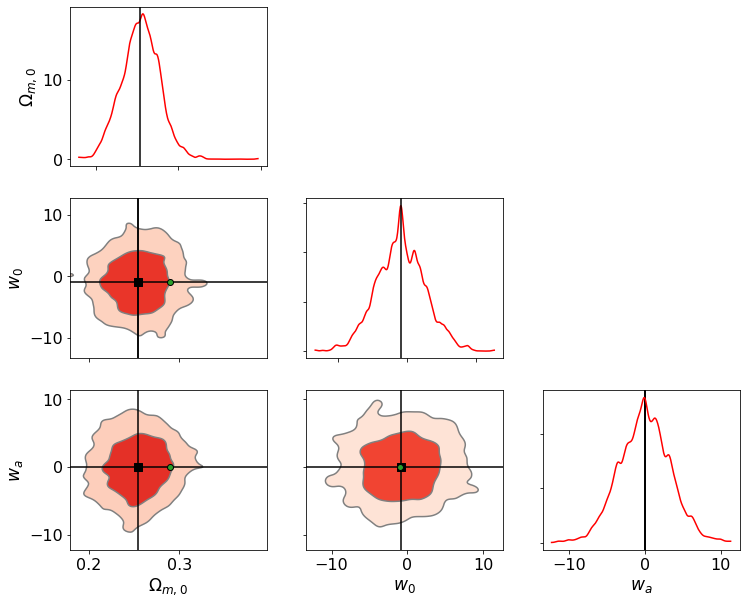

In [74]:
fig, ax = plt.subplots(3,3, figsize=(12,10))
labeller = az.labels.MapLabeller(var_name_map=var_dict)

#az.plot_pair(numpyro_data, kind='kde', marginals=True, figsize=(10,10), textsize=16, contour=False, labeller=labeller, reference_values=ref_dict, ax=ax, marginal_kwargs={'color':'green'},
#kde_kwargs={"contourf_kwargs": {"cmap": "Greens"}})

#az.plot_pair(idata_num, kind='kde', marginals=True, figsize=(10,10), textsize=16, contour=False, labeller=labeller, reference_values=ref_dict, kde_kwargs={"contourf_kwargs": {"cmap": "Blues"}},
#ax=ax, marginal_kwargs={'color':'blue'})


az.plot_pair(idata_em, kind='kde', marginals=True, figsize=(10,10), textsize=16, contour=False, labeller=labeller, reference_values=ref_dict, 
kde_kwargs={"hdi_probs": [0.68, 0.95], "contourf_kwargs": {"cmap": "Reds"}},
ax=ax, marginal_kwargs={'color':'red'},
point_estimate="mean"
)

[[<AxesSubplot:ylabel='theta\nChoate'> <AxesSubplot:>]
 [<AxesSubplot:xlabel='mu', ylabel='theta\nDeerfield'>
  <AxesSubplot:xlabel='theta\nChoate'>]]


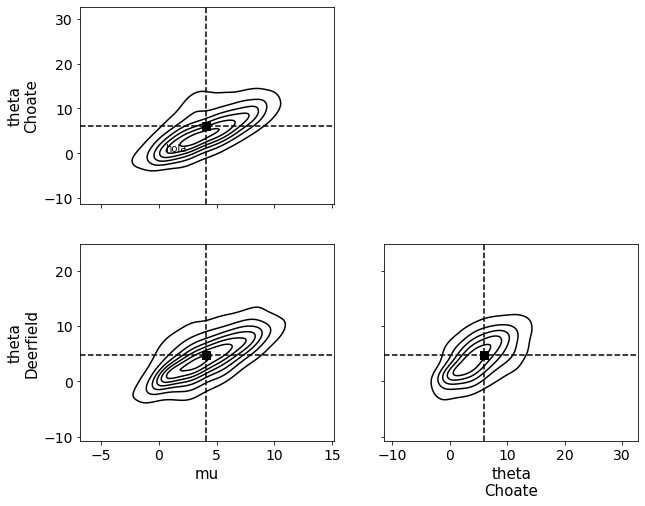

In [76]:
import matplotlib.pyplot as plt

import arviz as az

centered = az.load_arviz_data("centered_eight")

coords = {"school": ["Choate", "Deerfield"]}
ax = az.plot_pair(
    centered,
    var_names=["mu", "theta"],
    #kind=["scatter", "kde"],
    kind=["kde"],
    #kde_kwargs={"fill_last": False},
    #marginals=True,
    coords=coords,
    point_estimate='mean',
    point_estimate_kwargs={'ls':'--'},
    figsize=(10, 8)
)
print(ax)
ax[0,0].text(s='hola', x=0.5, y=0.5)
plt.show()

In [ ]:
ax.axvline

In [64]:
import jax
import emcee_jax

def log_prob(theta, a1=100.0, a2=20.0):
    x1, x2 = theta
    some_number = x1 + jax.numpy.sin(x2)
    log_prob_value = -(a1 * (x2 - x1**2)**2 + (1 - x1)**2) / a2

    # This second argument can be any PyTree
    return log_prob_value, {"some_number": some_number}

num_walkers, num_steps = 100, 1000
key1, key2, key3 = jax.random.split(jax.random.PRNGKey(0), 3)
coords = jax.random.normal(key1, shape=(num_walkers, 2))
sampler = emcee_jax.EnsembleSampler(log_prob)
state = sampler.init(key2, coords)
trace = sampler.sample(key3, state, num_steps)


In [68]:
trace.to_inference_data()

Inference data with groups:
	> posterior
	> sample_stats